In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
pip install scikit-learn==1.5.1 imbalanced-learn==0.12.3


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold # Import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble    import RandomForestClassifier
from sklearn.neighbors   import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree   import DecisionTreeClassifier
from xgboost    import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
def settings():
    %matplotlib inline
    %pylab inline

    sns.set(font_scale=1.6)

    # plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    # /display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
df=pd.read_csv("/kaggle/input/dataset-for-fraud/Fraud.csv")

# Checking Null Values

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

##### ***There is no null values in dataset so there is no handling of null values***

# Data Dimension

In [6]:
df.shape

(6362620, 11)

# Data Types and Structure

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Change Data Type

In [8]:
df['isFraud'] = df['isFraud'].map({1: 'yes', 0: 'no'})
df['isFlaggedFraud'] = df['isFlaggedFraud'].map({1: 'yes', 0: 'no'})

# Outlier in Catogorical Column

In [9]:
df['isFraud'].value_counts()

isFraud
no     6354407
yes       8213
Name: count, dtype: int64

This representing and imbalance dataset

In [10]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

# Outliers in Numerical Comulns

In [11]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Select numeric columns
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
                'oldbalanceDest', 'newbalanceDest']

# Fit the model
iso = IsolationForest(contamination=0.01, random_state=42)
df['outlier'] = iso.fit_predict(df[numeric_cols])

# Interpretation: -1 = Outlier, 1 = Normal
outliers = df[df['outlier'] == -1]



In [12]:
outliers.shape

(63622, 12)

In [13]:
print("Outlier Percentage",(outliers.shape[0]/df.shape[0])*100)

Outlier Percentage 0.9999339894571734


 **In fraud detection, outliers often represent actual fraud cases, and removing or imputing them would erase the very patterns the model needs to detect.**

# Multi-collinearity in Numerical Columns


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric features
X = df.select_dtypes(include=['number'])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          Feature         VIF
0            step    3.667288
1          amount    4.030910
2   oldbalanceOrg  466.818665
3  newbalanceOrig  468.557595
4  oldbalanceDest   72.018331
5  newbalanceDest   83.574443
6         outlier    3.517003


oldbalanceOrg & newbalanceOrig: Almost perfectly correlated — probably because one is often the other minus amount or plus something small.

oldbalanceDest & newbalanceDest: Also highly correlated — likely similar relationship.

and all other have normal colinearity


# Multicolinearity in Categorical Column

In [15]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [16]:
# calcCramerV(df['type'],df['isFraud'])

This indicating that there is no strong relationship between type and isFraud Column.

In [17]:
df.drop('outlier', axis=1, inplace=True)

# **Description Statistics**

In [18]:
num_attri= df.select_dtypes(exclude='object')
cat_attri = df.select_dtypes(include='object')
describe = num_attri.describe().T


In [19]:

from scipy.stats import skew, kurtosis
def calculate_stats(x):
    cv = x.std() / x.mean() if x.mean() != 0 else None
    skewness = skew(x, nan_policy='omit')
    kurt = kurtosis(x, nan_policy='omit', fisher=False)  # Pearson definition (normal=3)
    return pd.Series([cv, skewness, kurt], index=['CV', 'Skewness', 'Kurtosis'])

stat=df[num_attri.columns].apply(calculate_stats).T


In [20]:
describe.join(stat)

,count,mean,std,min,25%,50%,75%,max,CV,Skewness,Kurtosis
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,0.584772,0.375177,3.329069
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,3.357344,30.993942,1800.955291
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,3.463606,5.249135,35.964852
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,3.419485,5.176883,35.066958
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,3.088194,19.921753,951.673379
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,2.999298,19.352297,865.155829


## Obeservation
1. In step distribute between 1 hour and 743 hour which is alomost 31 days data
2. skweness is positive for all columns hence almost all column right skewd.
3. Coefficinent of variance is gretter than 25% for all column hence columns is not homogenes.
4. step column is nearly normal with just a bit more peak/tail heaviness compared to your other columns that are more strongly leptokurtic.
5. 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.




In [21]:
cat_attri.describe()

,type,nameOrig,nameDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620
unique,5,6353307,2722362,2,2
top,CASH_OUT,C1530544995,C1286084959,no,no
freq,2237500,3,113,6354407,6362604


## Observation
1. Frequency of Cash_Out transaction is more which is 2237500
2. unique value in nameOrig and name nameDest so can not be one hot encode.
3. Almost 8213 froud is happen but existing system only capture 16 which indicating very low accuracy of existing model.

# **Feature Engineering**

In [22]:
df1=df.copy()

In [23]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,no,no
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,no,no
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,yes,no
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,yes,no
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,no,no


In [24]:
df.drop('isFlaggedFraud', axis=1, inplace=True)

In [25]:
df['diff_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

df['nameOrig']=df['nameOrig'].apply(lambda i: i[0])
df['nameDest']=df['nameDest'].apply(lambda i: i[0])

In [26]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,diff_orig,diff_dest
0,1,PAYMENT,9839.64,C,170136.0,160296.36,M,0.0,0.0,no,-9839.64,0.0
1,1,PAYMENT,1864.28,C,21249.0,19384.72,M,0.0,0.0,no,-1864.28,0.0
2,1,TRANSFER,181.00,C,181.0,0.00,C,0.0,0.0,yes,-181.00,0.0
3,1,CASH_OUT,181.00,C,181.0,0.00,C,21182.0,0.0,yes,-181.00,-21182.0
4,1,PAYMENT,11668.14,C,41554.0,29885.86,M,0.0,0.0,no,-11668.14,0.0


In [27]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,diff_orig,diff_dest
6362615,743,CASH_OUT,339682.13,C,339682.13,0.0,C,0.00,339682.13,yes,-339682.13,339682.13
6362616,743,TRANSFER,6311409.28,C,6311409.28,0.0,C,0.00,0.00,yes,-6311409.28,0.00
6362617,743,CASH_OUT,6311409.28,C,6311409.28,0.0,C,68488.84,6379898.11,yes,-6311409.28,6311409.27
6362618,743,TRANSFER,850002.52,C,850002.52,0.0,C,0.00,0.00,yes,-850002.52,0.00
6362619,743,CASH_OUT,850002.52,C,850002.52,0.0,C,6510099.11,7360101.63,yes,-850002.52,850002.52


# Exploritery Data Analysis

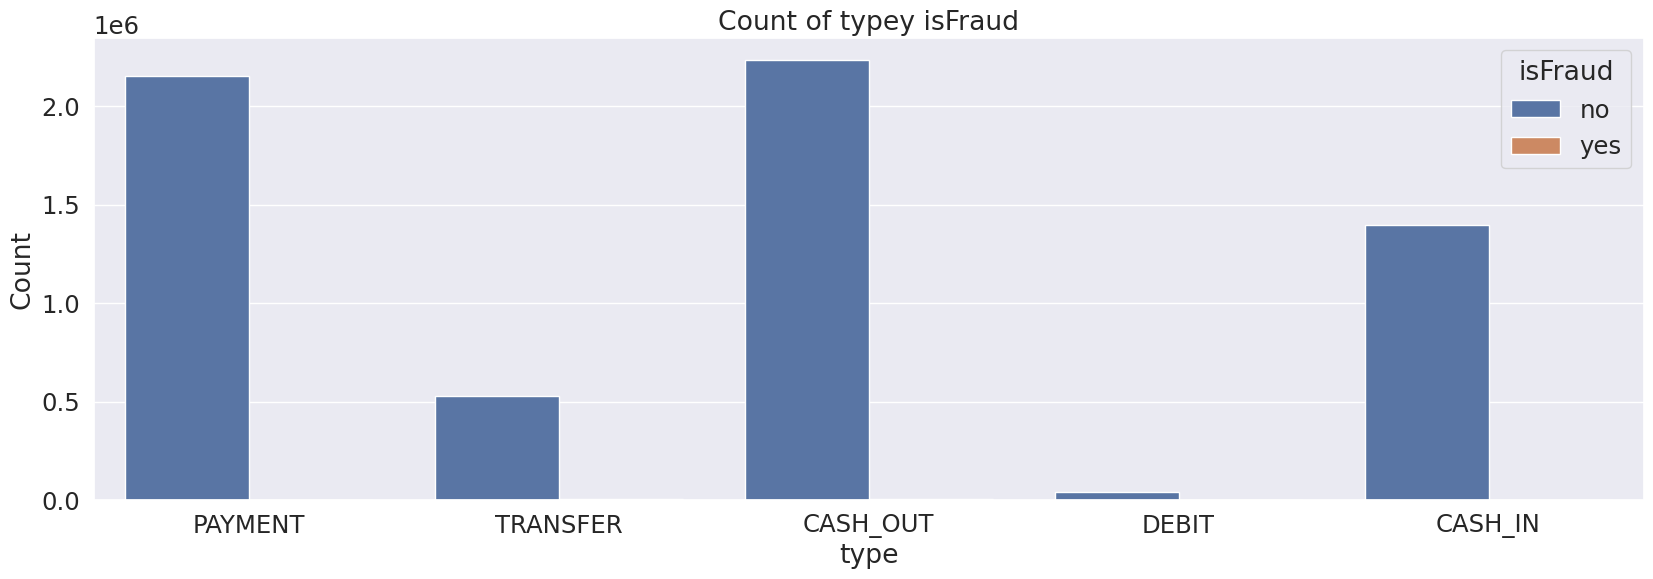

In [28]:
plt.figure(figsize=(20, 6)) # Optional: Adjust figure size
sns.countplot(x='type', hue='isFraud', data=df)

# Add title and labels for clarity
plt.title('Count of typey isFraud')
plt.xlabel('type')
plt.ylabel('Count')

# Display the plot
plt.show()

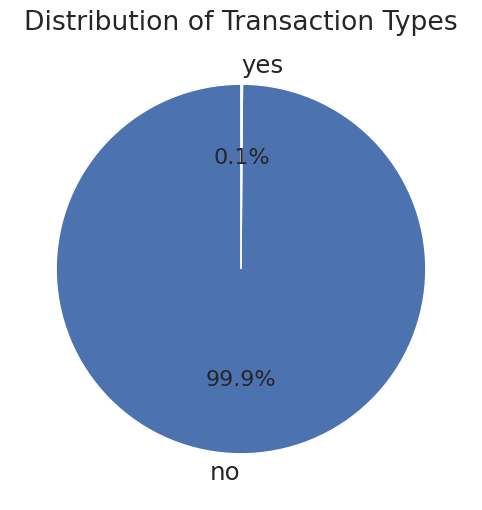

In [29]:
type_counts = df['isFraud'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90)

plt.title("Distribution of Transaction Types")
plt.show()

<Axes: xlabel='type', ylabel='amount'>

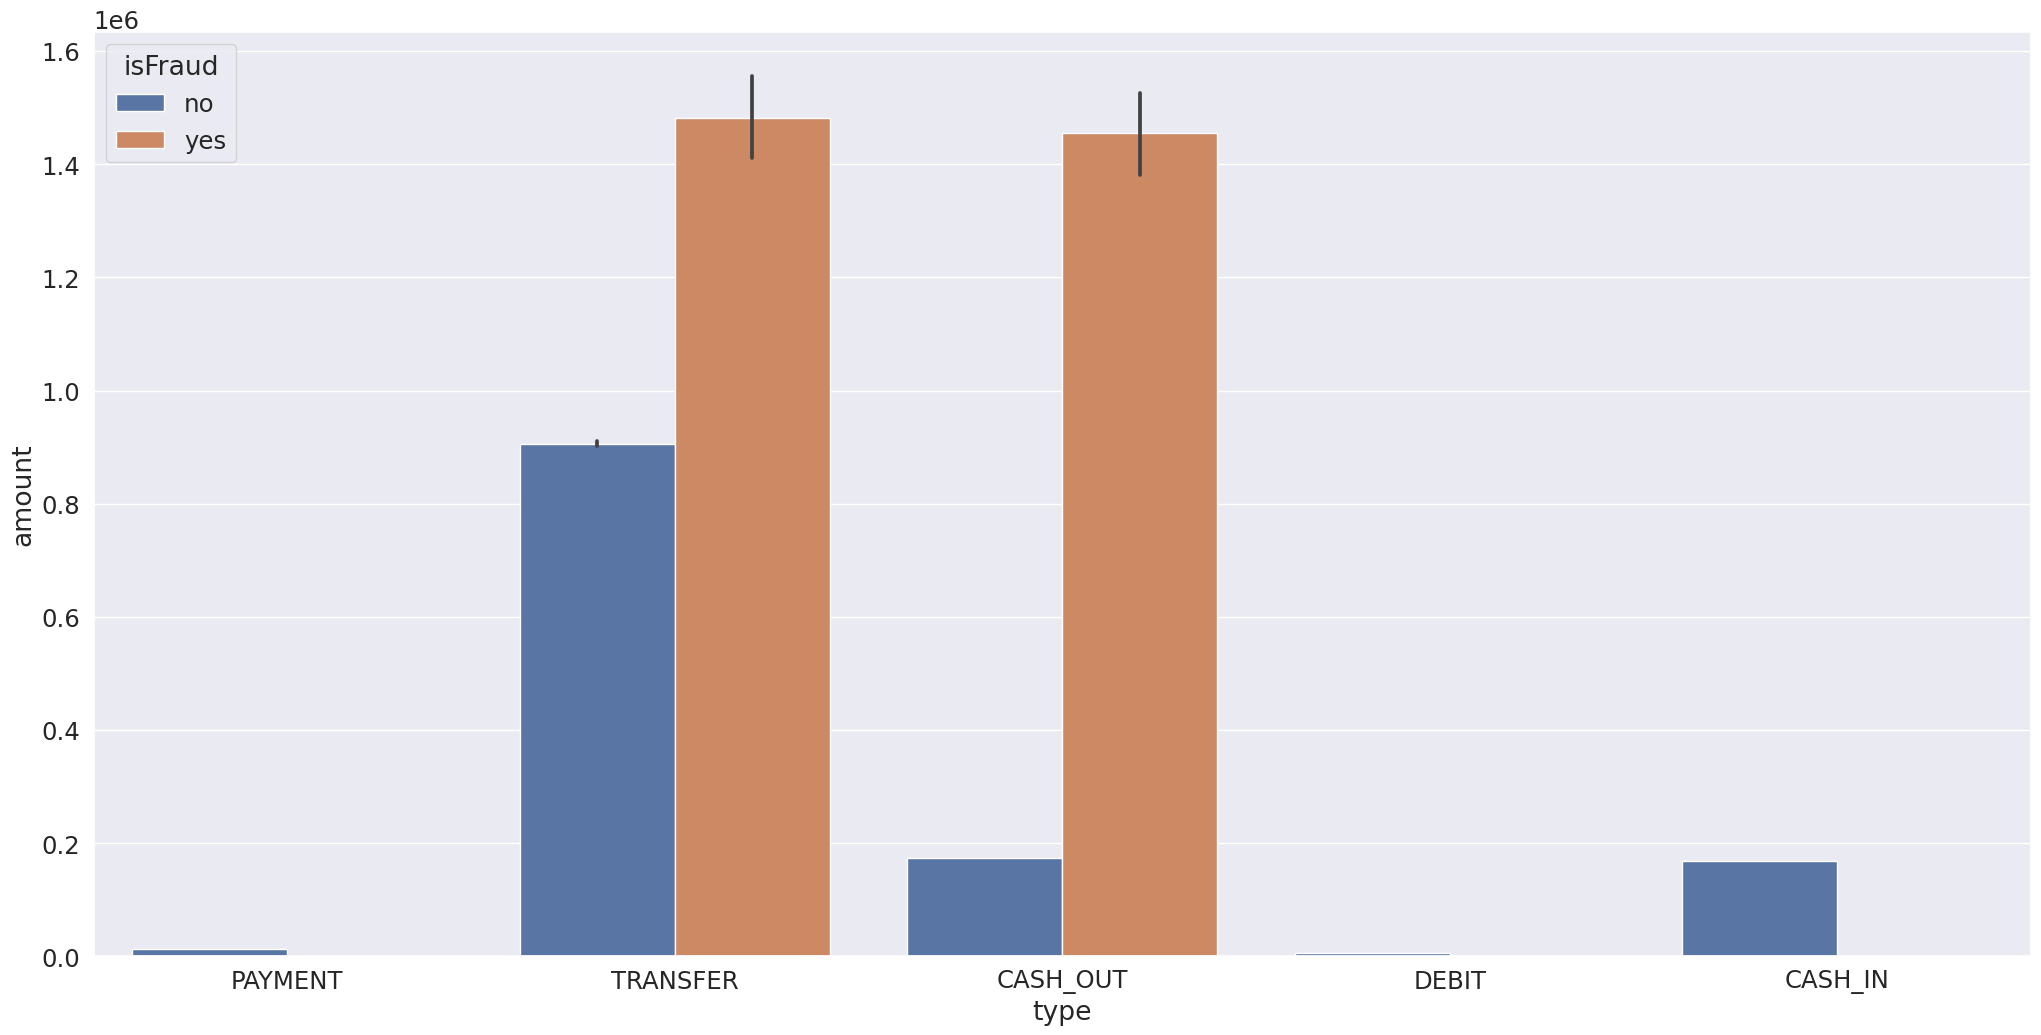

In [30]:
sns.barplot(data=df,x='type', y='amount', hue='isFraud')

According to this graph all froude hapeens thorugh Transfer and Cash_Out Transaction

<Axes: xlabel='amount', ylabel='type'>

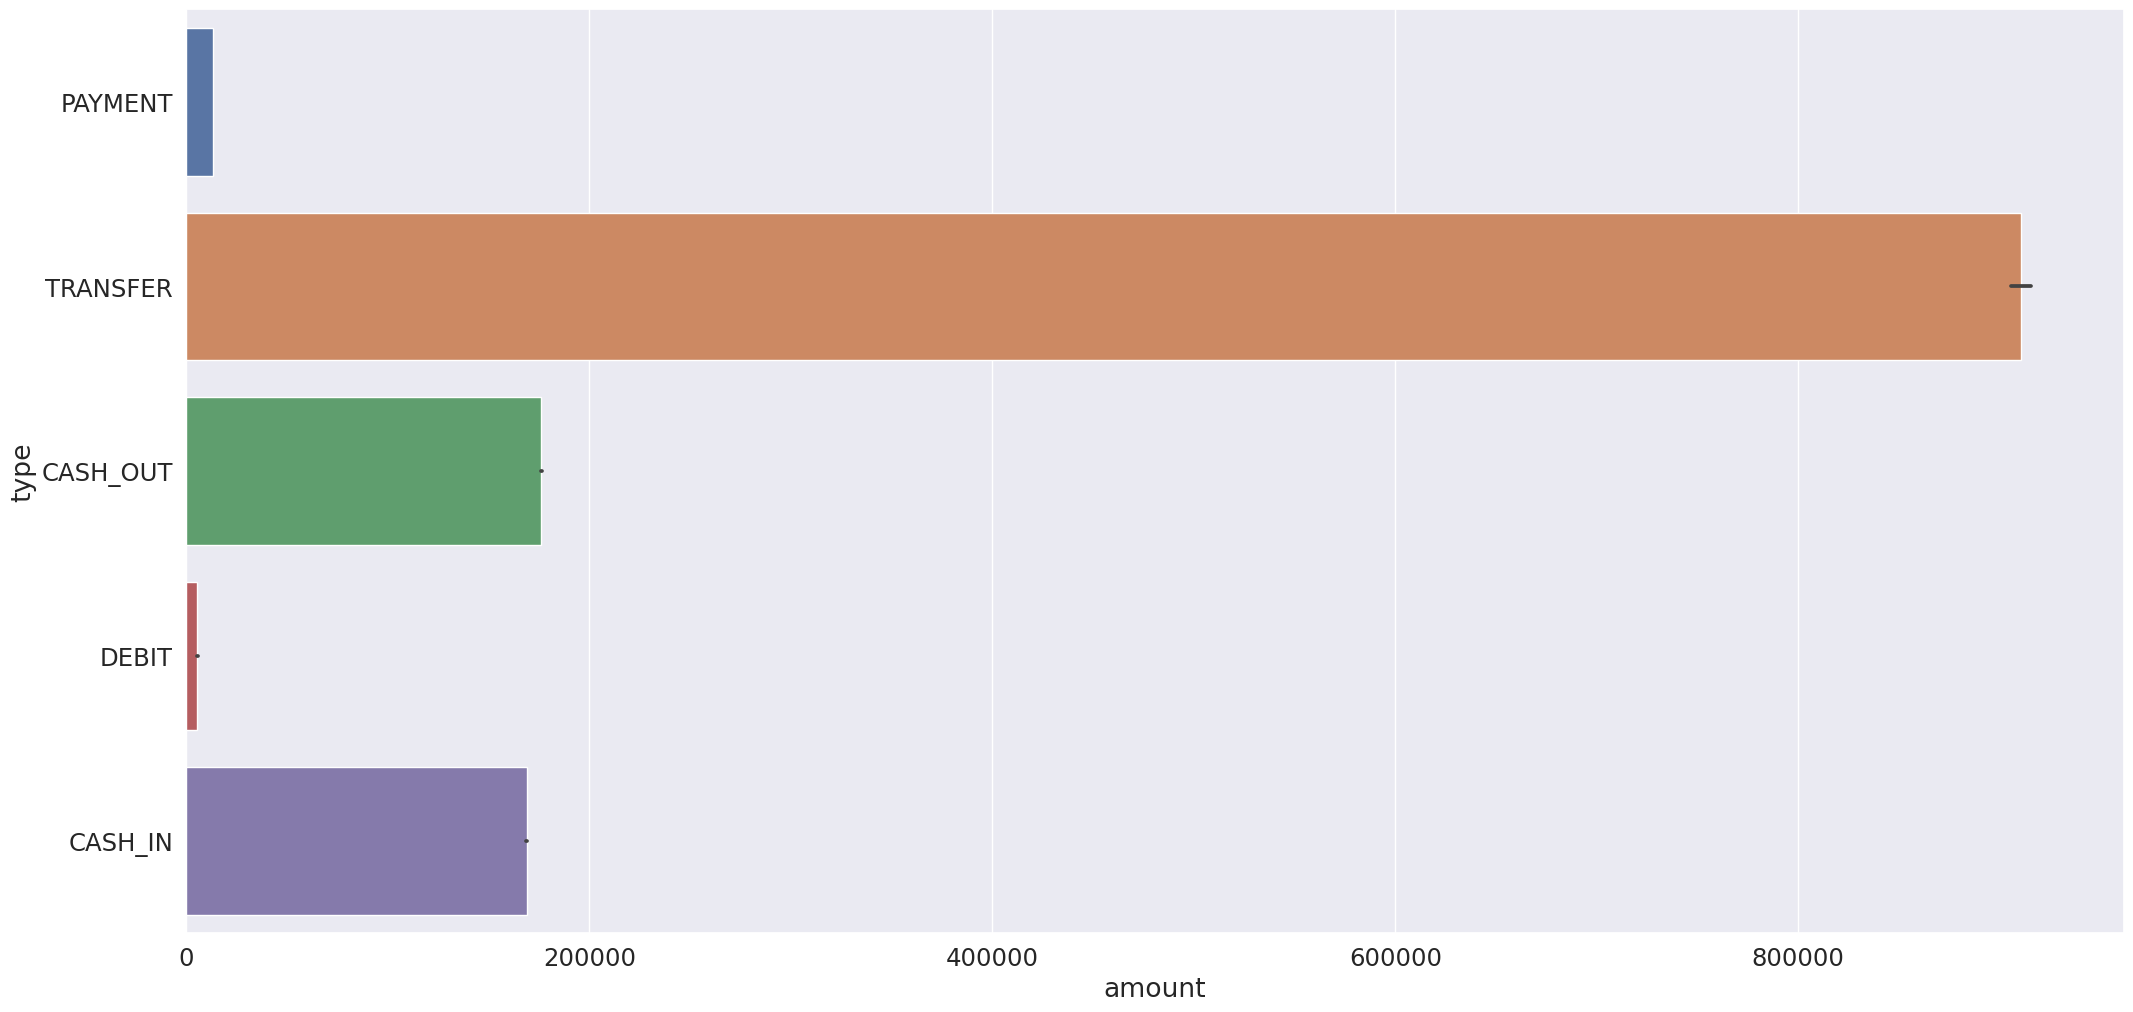

In [31]:
sns.barplot(data=df,y='type', x='amount')

Maximum trasaction happen through Transfer type

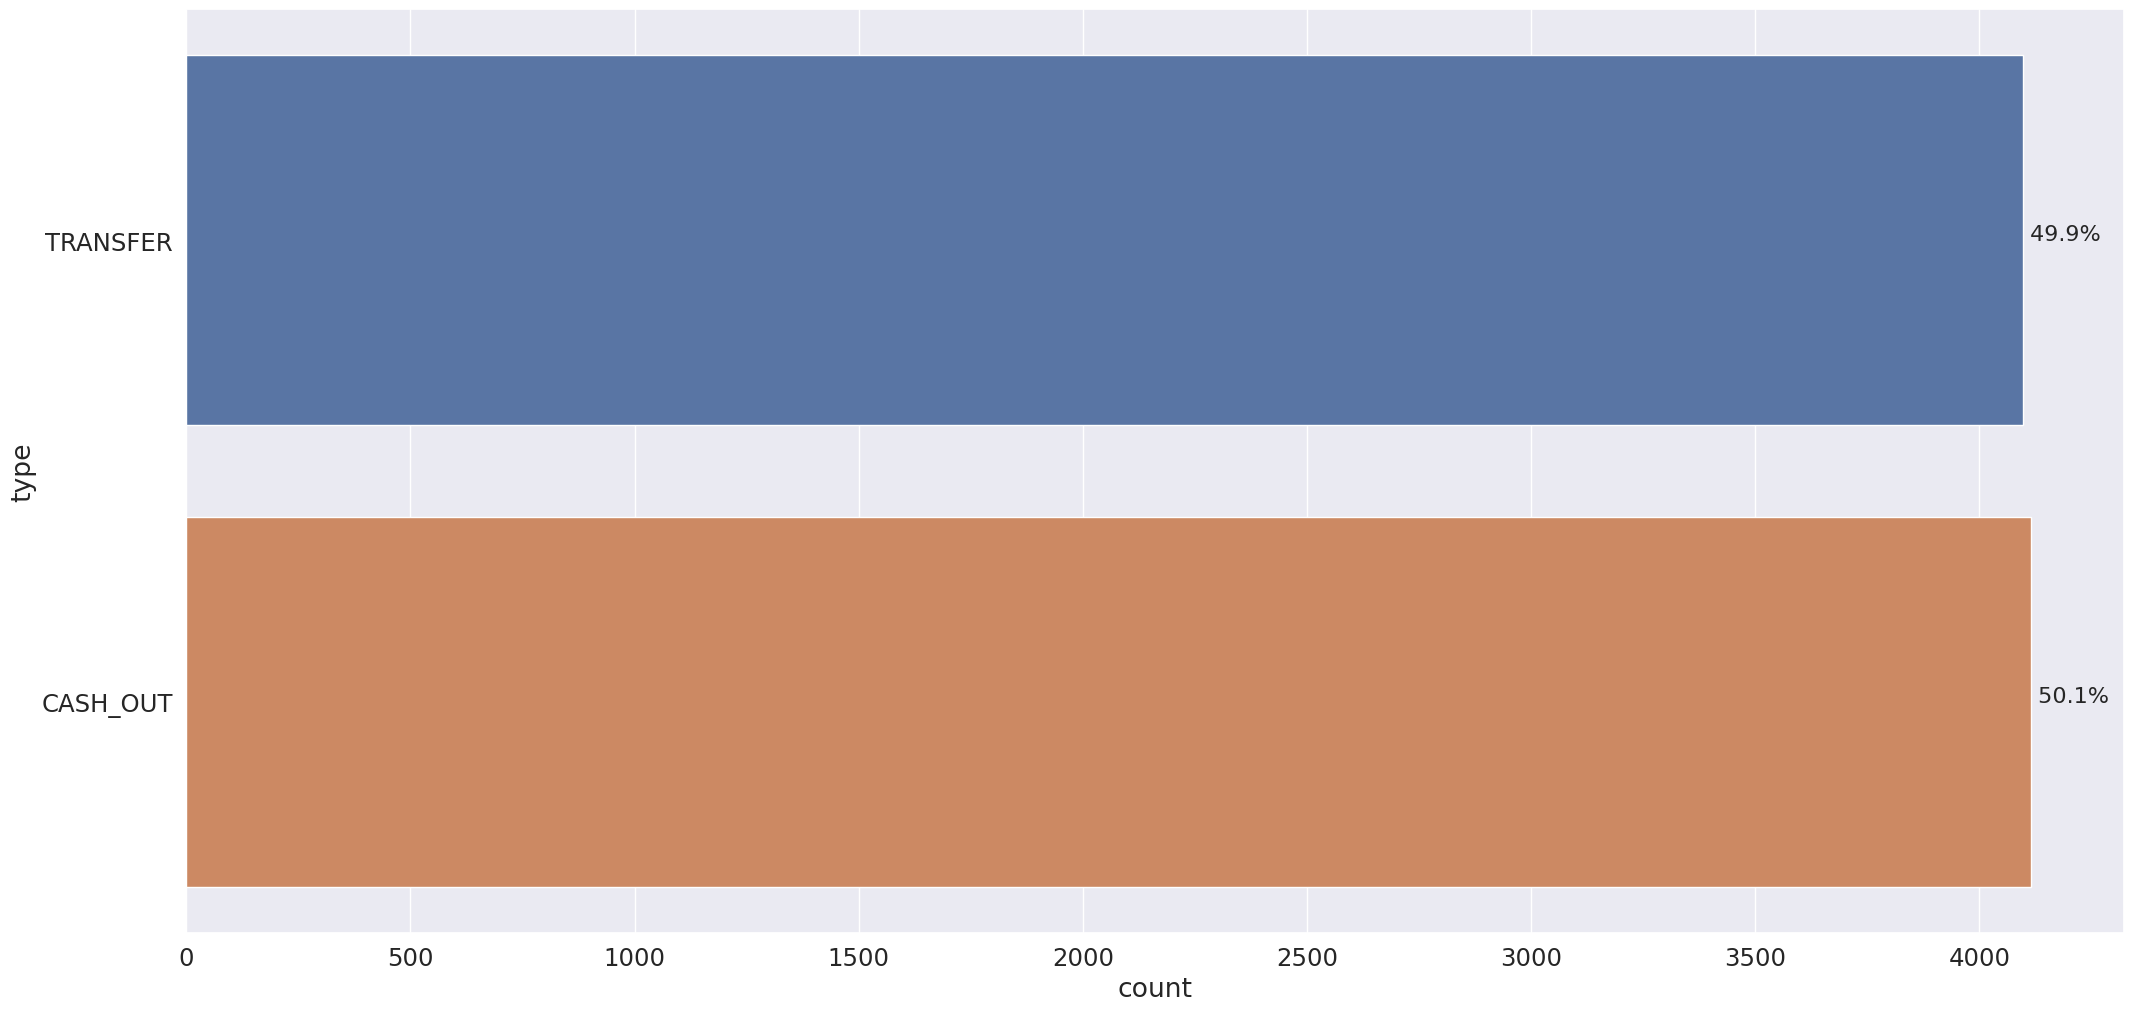

In [32]:
aux1 = df[df['isFraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

: The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

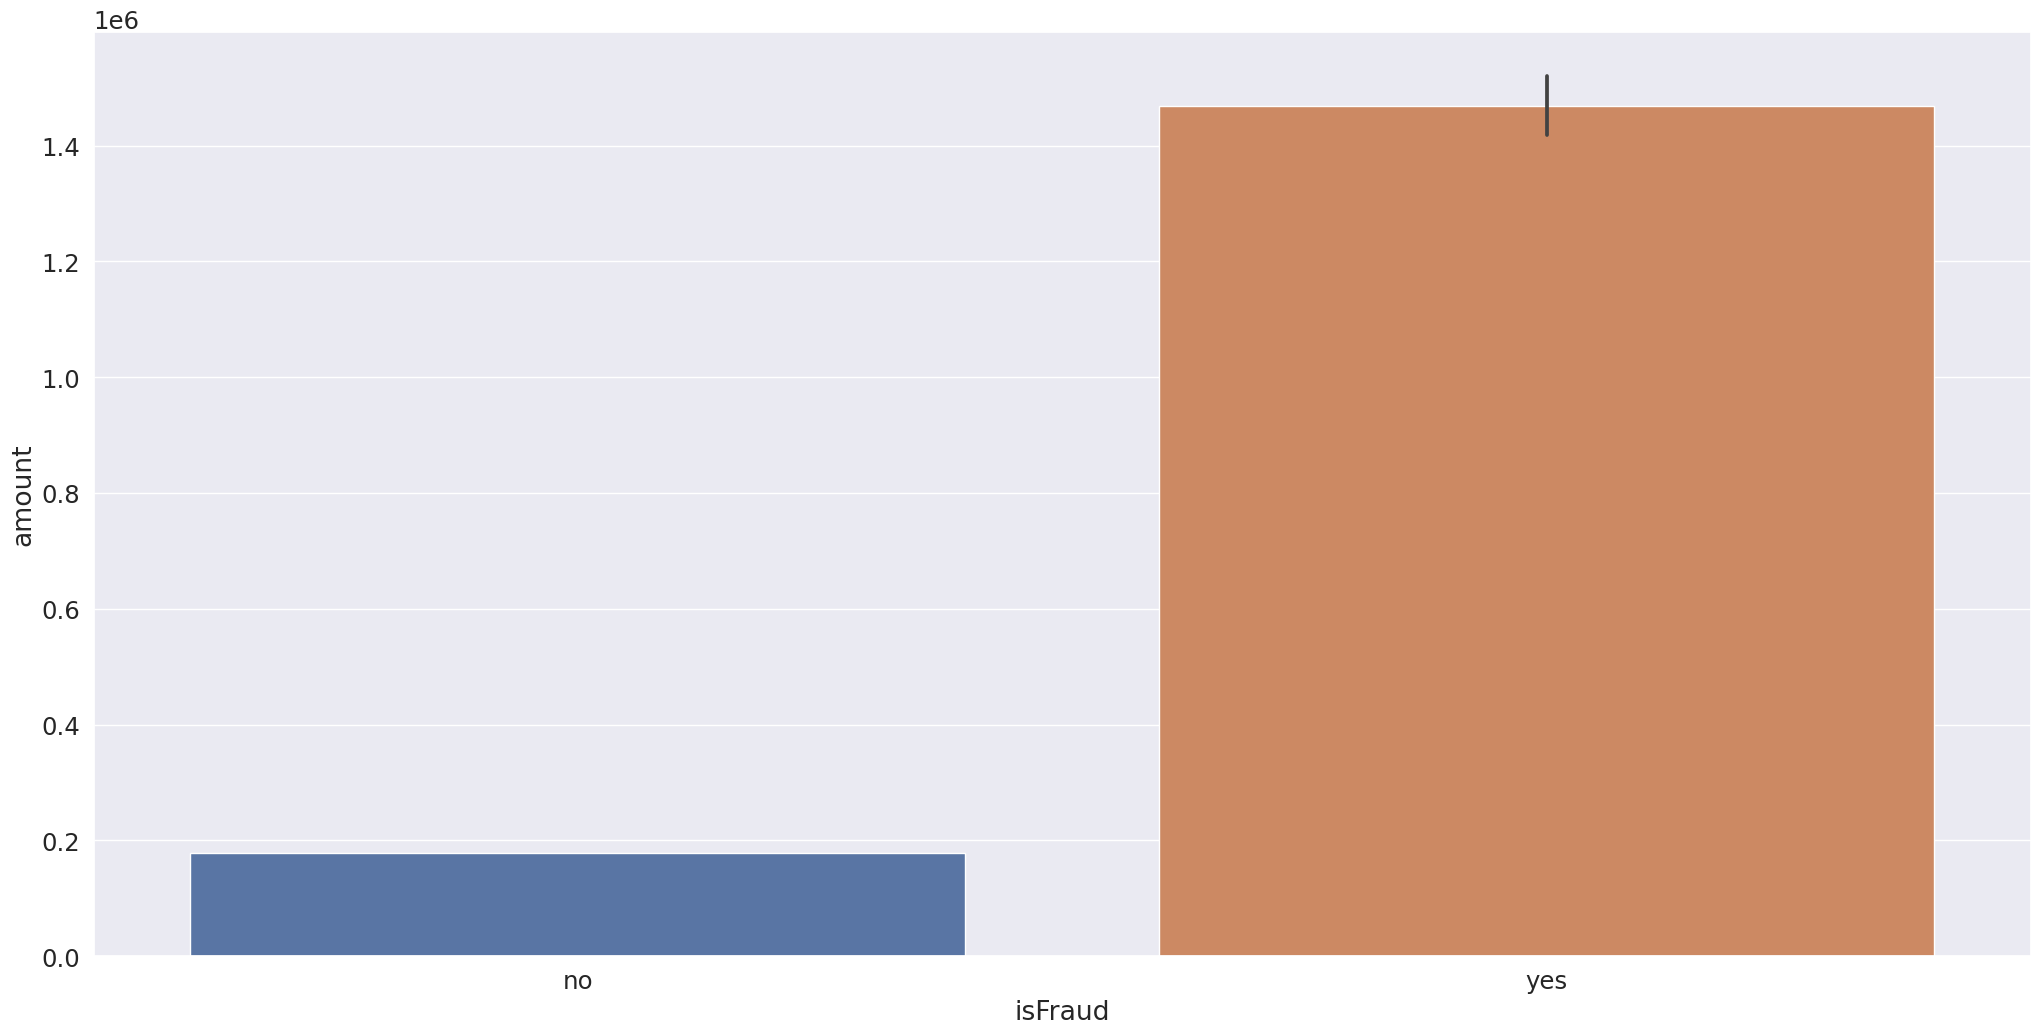

In [33]:
sns.barplot(y='amount', x='isFraud', data=df);

All frode ammont gretter than 10,000.but not any normal transaction ammount is gretter than 10,000   

In [34]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'diff_orig',
       'diff_dest'],
      dtype='object')

<Axes: xlabel='nameOrig', ylabel='amount'>

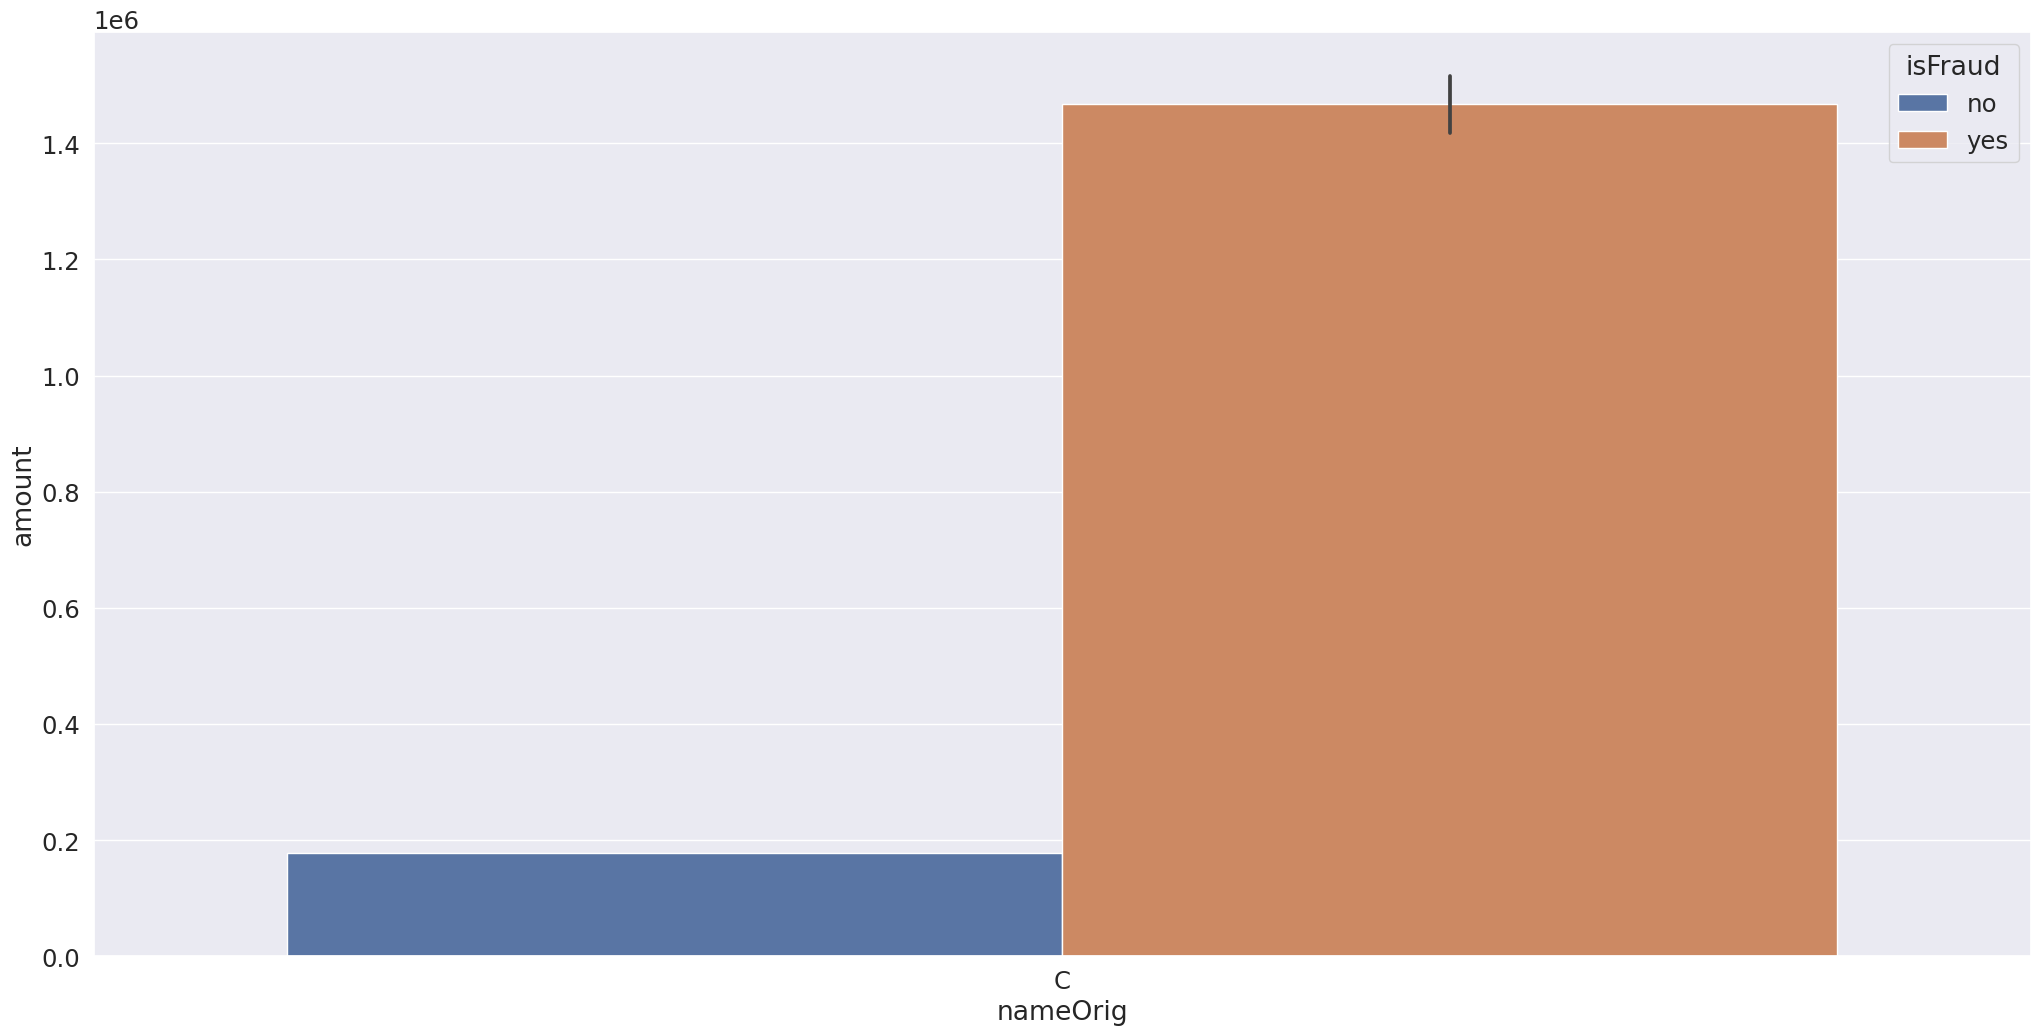

In [35]:
sns.barplot(data=df,x='nameOrig', y='amount', hue='isFraud')

In [36]:
df['nameDest'].value_counts()

nameDest
C    4211125
M    2151495
Name: count, dtype: int64

<Axes: xlabel='nameDest', ylabel='amount'>

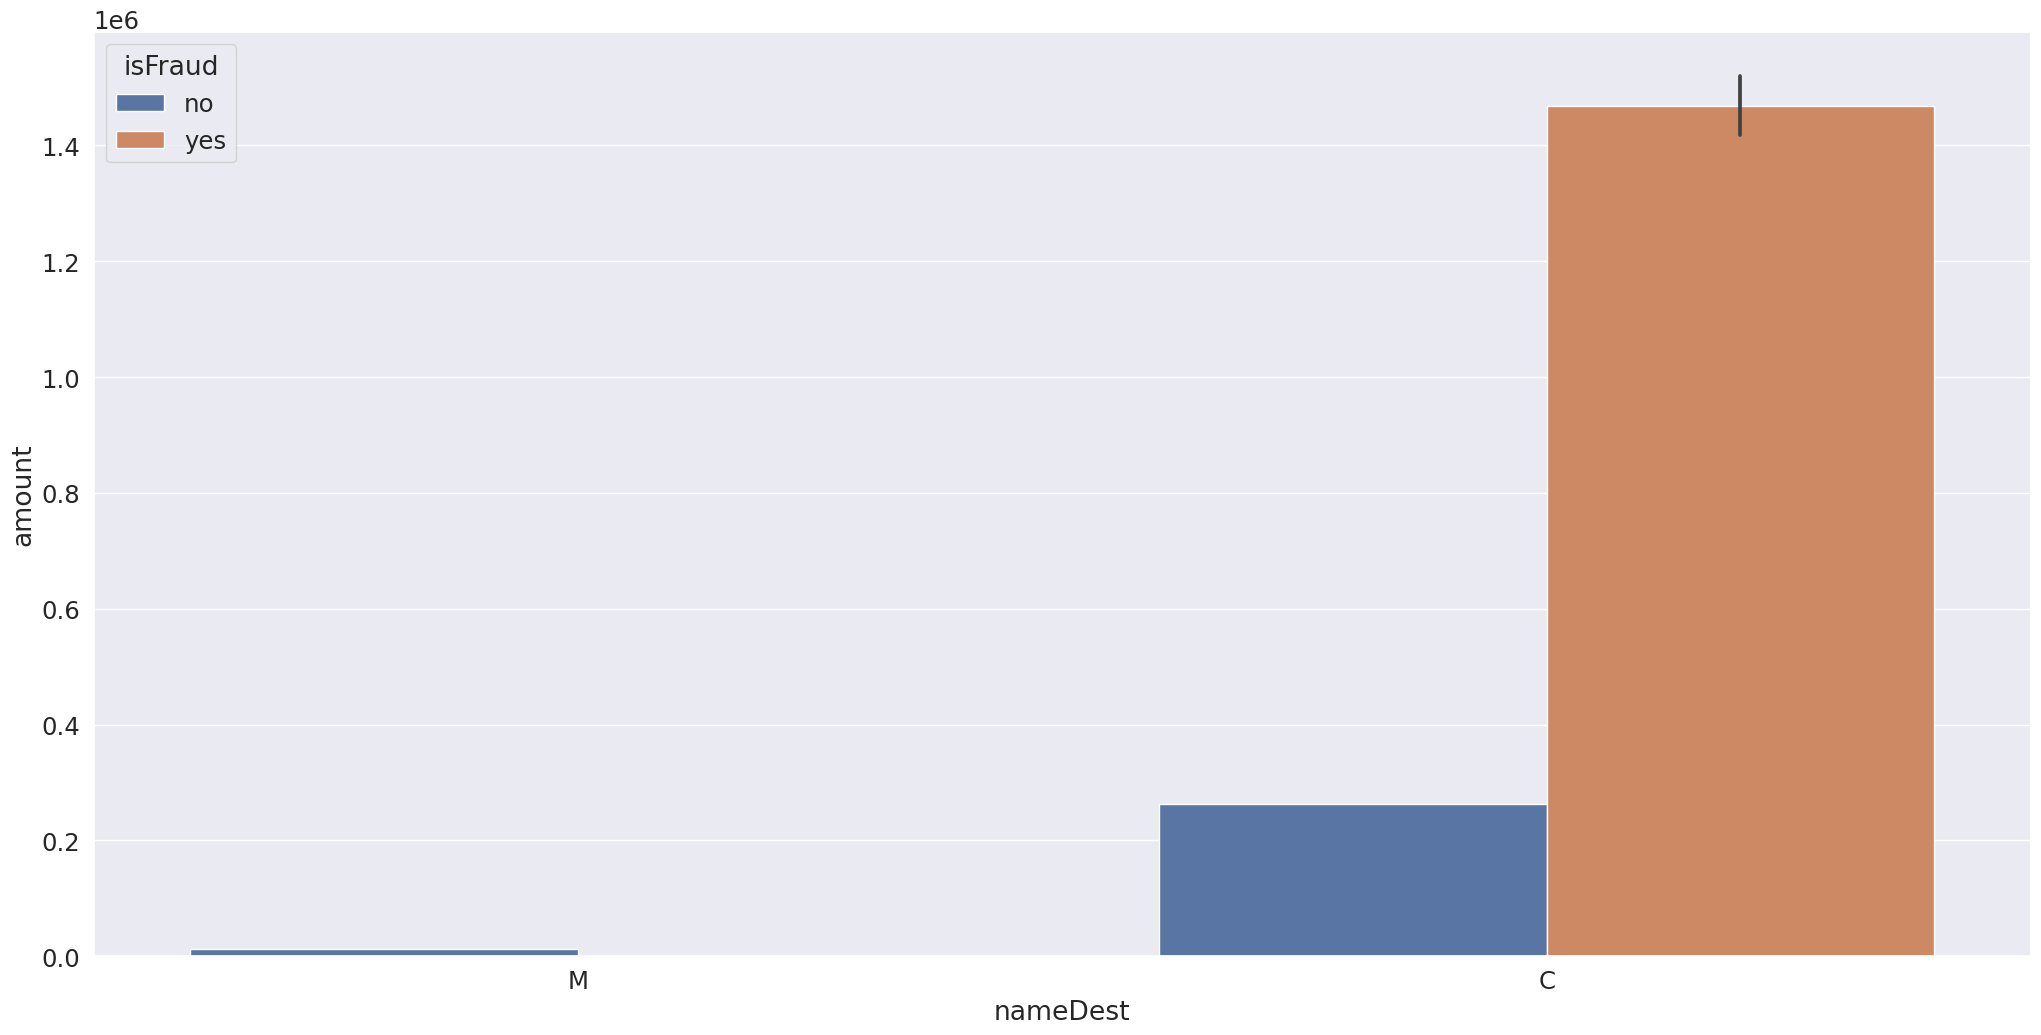

In [37]:
sns.barplot(data=df,x='nameDest', y='amount', hue='isFraud')

c type customer recive ammount high froude rate happen with them only

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


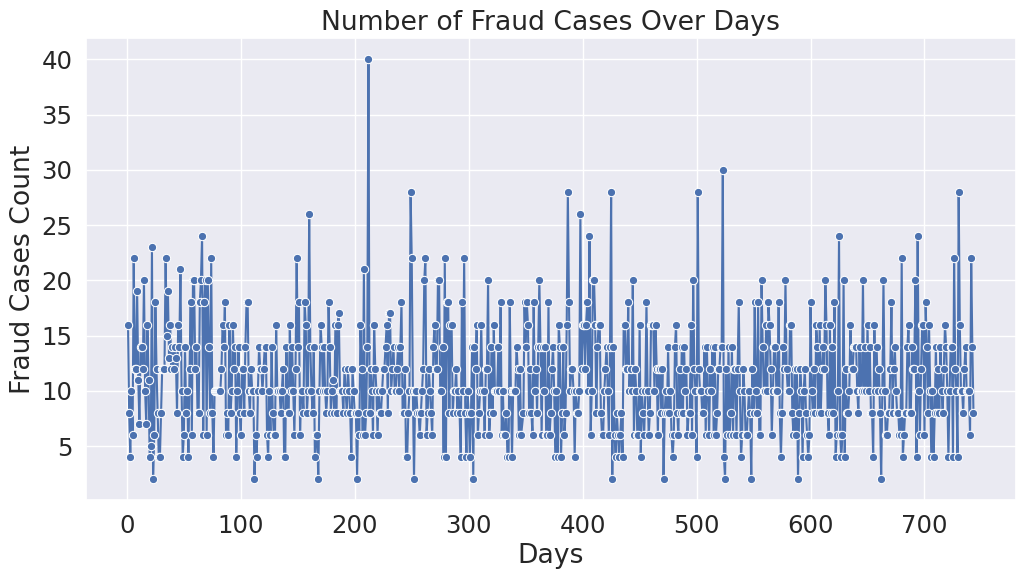

In [38]:
fraud_counts = df[df['isFraud'] == 'yes'].groupby('step').size()

plt.figure(figsize=(12,6))
sns.lineplot(x=fraud_counts.index, y=fraud_counts.values, marker="o")

plt.title("Number of Fraud Cases Over Days")
plt.xlabel("Days")
plt.ylabel("Fraud Cases Count")
plt.show()

In [39]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,diff_orig,diff_dest
0,1,PAYMENT,9839.64,C,170136.0,160296.36,M,0.0,0.0,no,-9839.64,0.0
1,1,PAYMENT,1864.28,C,21249.0,19384.72,M,0.0,0.0,no,-1864.28,0.0
2,1,TRANSFER,181.00,C,181.0,0.00,C,0.0,0.0,yes,-181.00,0.0
3,1,CASH_OUT,181.00,C,181.0,0.00,C,21182.0,0.0,yes,-181.00,-21182.0
4,1,PAYMENT,11668.14,C,41554.0,29885.86,M,0.0,0.0,no,-11668.14,0.0


# **Data Preparation**

## Spliting into Train, Valid and Test

In [40]:
X = df.drop(columns=['isFraud','nameOrig','nameDest'], axis=1)
y = df['isFraud'].map({'yes': 1, 'no': 0})

In [41]:
from sklearn.model_selection import train_test_split
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

In [42]:
X_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,diff_orig,diff_dest
1040065,94,PAYMENT,2348.05,2451.00,102.95,0.00,0.00,-2348.05,0.00
1492298,142,PAYMENT,14733.99,0.00,0.00,0.00,0.00,0.00,0.00
5834098,402,CASH_IN,31697.50,7082965.34,7114662.84,410302.17,378604.67,31697.50,-31697.50
3724511,278,PAYMENT,1124.60,0.00,0.00,0.00,0.00,0.00,0.00
1974661,178,CASH_OUT,99740.18,51071.00,0.00,0.00,99740.18,-51071.00,99740.18


# **Building a machine Learning Pipeline**

In [43]:
! pip install category_encoders

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTENC # Import SMOTENC

def fraud_pipeline(X,y,model):
    """
    Build, train, and evaluate a fraud detection pipeline with a given model object.

    Parameters:
        X : DataFrame - features
        y : Series - target
        model : sklearn model object (e.g., RandomForestClassifier(), LogisticRegression())

    Returns:
        pipeline : trained pipeline
    """

    num_features = X.select_dtypes(include=['int64', 'float64']).columns
    cat_features = X.select_dtypes(include=['object']).columns

    # Preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", MinMaxScaler(), num_features),
            ("encoder", TargetEncoder(), cat_features)
        ],
        remainder='passthrough' # Keep other columns (if any)
    )

    # Define the pipeline without SMOTE
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline

In [45]:
# helper Function:
from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
def ml_scores(model_name, y_true, y_pred):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)},
                        index=[model_name])

In [46]:
from sklearn.metrics import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold # Import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
def cross_Validation_results(model_name, model, x, y, verbose=1):

    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []


    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for index_train, index_test in skf.split(x, y):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        pipe=fraud_pipeline(X,y,model)

        ## training the model
        pipe.fit(x_train, y_train)
        y_pred = pipe.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))


    '''results'''
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)

    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1. logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
pipe=fraud_pipeline(X,y,lg)

In [48]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'diff_orig', 'diff_dest'],
      dtype='object')),
                                                 ('encoder', TargetEncoder(),
                                                  Index(['type'], dtype='object'))])),
                ('model', LogisticRegression())])

In [49]:
y_pred=pipe.predict(X_test)
ml_scores('Logistic Regression', y_test, y_pred)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.588,0.997,0.176,0.299,0.299


In [50]:
lg_cv = cross_Validation_results('Logistic Regression',lg, X, y)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.585 +/- 0.022,0.989 +/- 0.019,0.17 +/- 0.044,0.288 +/- 0.06,0.288 +/- 0.06


In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      0.18      0.30      1643

    accuracy                           1.00   1272524
   macro avg       1.00      0.59      0.65   1272524
weighted avg       1.00      1.00      1.00   1272524



In [52]:
from sklearn.svm import SVC
from sklearn.ensemble    import RandomForestClassifier
from sklearn.neighbors   import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree   import DecisionTreeClassifier
from xgboost    import XGBClassifier
from lightgbm import LGBMClassifier

# **2. Support Vector Machine**

In [53]:
# svc=SVC()
# pipe=fraud_pipeline(X,y,svc)
# pipe.fit(X_train,y_train)


In [54]:
# y_pred=pipe.predict(X_test)
# ml_scores('Support Vector Machine', y_test, y_pred)

In [55]:
# lg_cv = cross_Validation_results('Logistic Regression',svc, X, y)
# lg_cv

In [56]:
# print(classification_report(y_test,y_pred))

# 3. Random Forest

In [57]:
rf=RandomForestClassifier()
pipe=fraud_pipeline(X,y,rf)
pipe.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'diff_orig', 'diff_dest'],
      dtype='object')),
                                                 ('encoder', TargetEncoder(),
                                                  Index(['type'], dtype='object'))])),
                ('model', RandomForestClassifier())])

In [58]:
y_pred=pipe.predict(X_test)
ml_scores('Random forest Classifier', y_test, y_pred)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random forest Classifier,0.914,0.979,0.828,0.897,0.897


In [59]:
lg_cv = cross_Validation_results('RandomForestClassifier',rf, X, y)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.915 +/- 0.004,0.973 +/- 0.004,0.831 +/- 0.009,0.896 +/- 0.006,0.896 +/- 0.006


In [60]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.83      0.90      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



# **4. K Nearest Neighbors**

In [77]:
knn=KNeighborsClassifier()
pipe=fraud_pipeline(X,y,knn)
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'diff_orig', 'diff_dest'],
      dtype='object')),
                                                 ('encoder', TargetEncoder(),
                                                  Index(['type'], dtype='object'))])),
                ('model', KNeighborsClassifier())])

In [78]:
y_pred=pipe.predict(X_test)
ml_scores('K Nearest Neighbors', y_test, y_pred)

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.801,0.94,0.603,0.734,0.734


In [79]:
lg_cv = cross_Validation_results('K Nearest Neighbors',knn, X, y)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.807 +/- 0.002,0.94 +/- 0.008,0.614 +/- 0.005,0.742 +/- 0.005,0.742 +/- 0.005


In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.94      0.60      0.73      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.80      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524



# **5. XGBoost**

In [65]:
xgb = XGBClassifier()
pipe=fraud_pipeline(X,y,xgb)
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'diff_orig', 'diff_dest'],
      dtype='object')),
                                                 ('encoder', TargetEncoder(),
                                                  Index(['type'], dtype='object'))])),
                ('model',
                 XGBClassifier(base_score=None, booster...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [66]:
y_pred=pipe.predict(X_test)
ml_scores('XGBoost', y_test, y_pred)

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.929,0.963,0.858,0.908,0.908


In [67]:
lg_cv = cross_Validation_results('XGboost',xgb, X, y)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.933 +/- 0.005,0.963 +/- 0.005,0.867 +/- 0.01,0.912 +/- 0.007,0.912 +/- 0.007


In [68]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.86      0.91      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.93      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



# **6. Decision Tree Classifier**

In [69]:
DT=DecisionTreeClassifier()
pipe=fraud_pipeline(X,y,DT)
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'diff_orig', 'diff_dest'],
      dtype='object')),
                                                 ('encoder', TargetEncoder(),
                                                  Index(['type'], dtype='object'))])),
                ('model', DecisionTreeClassifier())])

In [70]:
y_pred=pipe.predict(X_test)
ml_scores('Decision Tree Classifier', y_test, y_pred)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Decision Tree Classifier,0.938,0.872,0.877,0.875,0.874


In [71]:
lg_cv = cross_Validation_results('Decision Tree Classifier',DT, X, y)
lg_cv

Fold K=1
Fold K=2
Fold K=3


,Balanced Accuracy,Precision,Recall,F1,Kappa
Decision Tree Classifier,0.936 +/- 0.003,0.886 +/- 0.006,0.872 +/- 0.006,0.879 +/- 0.005,0.879 +/- 0.005


In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.87      0.88      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.94      0.94      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



# **7. LGBMClassifier**

In [73]:
lightgbm = LGBMClassifier()
pipe=fraud_pipeline(X,y,lightgbm)
pipe.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 5256, number of negative: 4066820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.317192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4072076, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651246
[LightGBM] [Info] Start training from score -6.651246


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'diff_orig', 'diff_dest'],
      dtype='object')),
                                                 ('encoder', TargetEncoder(),
                                                  Index(['type'], dtype='object'))])),
                ('model', LGBMClassifier())])

In [74]:
y_pred=pipe.predict(X_test)
ml_scores('LGBMClassifier', y_test, y_pred)

,Balanced Accuracy,Precision,Recall,F1,Kappa
LGBMClassifier,0.618,0.255,0.237,0.246,0.245


In [75]:
lg_cv = cross_Validation_results('LGBMClassifier',lightgbm, X, y)
lg_cv

Fold K=1
[LightGBM] [Info] Number of positive: 6571, number of negative: 5083525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651094
[LightGBM] [Info] Start training from score -6.651094
Fold K=2
[LightGBM] [Info] Number of positive: 6571, number of negative: 5083525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features

,Balanced Accuracy,Precision,Recall,F1,Kappa
LGBMClassifier,0.714 +/- 0.069,0.305 +/- 0.174,0.429 +/- 0.137,0.335 +/- 0.135,0.334 +/- 0.135


In [76]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.25      0.24      0.25      1643

    accuracy                           1.00   1272524
   macro avg       0.63      0.62      0.62   1272524
weighted avg       1.00      1.00      1.00   1272524



# HyperParameter tuning using Optuna 

In [81]:
! pip install optuna

In [82]:
import optuna
# Optuna objective function
def objective(trial):

    # Suggest hyperparameters for Decision Tree
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
    }

    # Create Decision Tree model with suggested hyperparams
    model = DecisionTreeClassifier(**params, random_state=42)

    # Run your cross validation function
    results = cross_Validation_results("DecisionTree", model, X, y, verbose=0)

    # Since results is a DataFrame, we extract the metric you want to optimize
    # Let's optimize Balanced Accuracy
    score_str = results.loc["DecisionTree", "Balanced Accuracy"]
    score = float(score_str.split(" ")[0])  # Extract mean value before '+/-'

    return score

# Run Optuna optimization
study = optuna.create_study(direction="maximize")  # we want to maximize balanced accuracy
study.optimize(objective, n_trials=30)

print("Best Parameters:", study.best_params)
print("Best Balanced Accuracy:", study.best_value)


[I 2025-08-17 06:00:27,515] A new study created in memory with name: no-name-bb258f1a-92ac-4bc1-b59c-14d2dbb348f1
[I 2025-08-17 06:03:16,707] Trial 0 finished with value: 0.894 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.894.
[I 2025-08-17 06:05:27,417] Trial 1 finished with value: 0.898 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.898.
[I 2025-08-17 06:07:15,413] Trial 2 finished with value: 0.86 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.898.
[I 2025-08-17 06:08:51,273] Trial 3 finished with value: 0.898 and parameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 

Best Parameters: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': None}
Best Balanced Accuracy: 0.92
